# Viscous streaming flow for a pair of oscillating cylinders

In [1]:
using ViscousStreaming

┌ Info: Precompiling ViscousStreaming [47fb7046-13b0-40db-b6a6-74fa44cf0959]
└ @ Base loading.jl:1242


In [2]:
using ProgressMeter
using JLD
import JLD: save, load
using Statistics
import Statistics: mean

In [3]:
using Plots
pyplot()
clibrary(:colorbrewer)
default(grid = false)

### Solve for small-amplitude oscillation of a cylindrical body

The motion of the body is described by oscillatory small-amplitude translation,

$$V_b(\xi,t) = \epsilon \hat{U}(t)$$

where $\epsilon \ll 1$, $\hat{U}(t)$ is a periodic velocity with unit amplitude, and $\xi \in S_b$ (i.e. it lies on the body surface). The associated position of any point on the surface of the body is then described by

$$X_b(\xi,t) = \xi + \epsilon \int_0^t \hat{U}(\tau)d\tau.$$

We will write the flow field in asympotic form, e.g. $v = \epsilon v_1 + \epsilon^2 v_2$, and seek to solve two asymptotic levels of equation (for vorticity)

$$\dfrac{\partial w_1}{\partial t} - \dfrac{1}{Re} \nabla^2 w_1 = 0$$

subject to boundary condition $v_1(\xi,t) = \hat{U}(t)$ for all $\xi \in S_b$. Note that the boundary condition is applied at the initial location of the surface, not its time-varying location.

And at second order,

$$\dfrac{\partial w_2}{\partial t} - \dfrac{1}{Re} \nabla^2 w_2 = -\nabla\cdot(v_1 w_1),$$

subject to boundary condition $v_2(\xi,t) = -\int_0^t \hat{U}(\tau)d\tau \cdot \nabla v_1(\xi,t)$ for all $\xi \in S_b$. This is also applied at the initial location of the surface.

Thus, to solve this problem, we will set up a state vector that contains $w_1$, $w_2$, and an unscaled 'body' state $x_c$, $y_c$. These latter components will be used to hold the components of $\Delta\hat{X} \equiv \int_0^t \hat{U}(\tau)d\tau$.

A fluid particle, initially at a location $x$, is subjected to a slightly different velocity, $U(x,t)$, over the ensuing oscillation period, since it is advected by the local velocity to sample nearby points. Its first-order velocity is simply $U_1(x,t) = v_1(x,t)$. Its second order velocity, however, is

$$U_2(x,t) = v_2(x,t) + \int_0^t v_1(x,\tau)d\tau \cdot \nabla v_1(x,t)$$

In particular, if the particle is initially on the surface, $x \in S_b$, then $v_1 = \hat{U}$, and the second term of this expression above cancels $v_2$, so that $U_2 = 0$. This ensures that the particle continues to oscillate with the body's surface velocity. Let us define an Eulerian displacement field,

$$\Delta X(x,t) = \int_0^t v(x,\tau)d\tau, \quad \Delta X(x,0) = 0,$$

or, equivalently,

$$\dfrac{d\Delta X}{dt} = v(x,t), \quad \Delta X(x,0) = 0.$$

Then, expanding $\Delta X$ in an asymptotic sequence, $\Delta X = \epsilon \Delta X_1 + \epsilon^2 \Delta X_2$, we have

$$U_2(x,t) = v_2(x,t) + \Delta X_1(x,t) \cdot \nabla v_1(x,t)$$

### Set the oscillation parameters

In [4]:
Re = 40.0
ϵ = 0.1

0.1

### Set the motion for Navier-Stokes solution
Here, we seek to set up a motion that will describe a sequence of oscillations from one cylinder to the other

#### First, set the basic oscillatory motion

In [5]:
Ω = 1.0  # angular frequency
Ax = 1.0 # x amplitude (before scaling by ϵ)
ϕx = 0.0 # phase lead of x motion
Ay = 0.0 # y amplitude
ϕy = 0.0 # phase lead of y motion
basicoscil = RigidBodyMotions.Oscillation(Ω,Ax,ϕx,Ay,ϕy)
Tp = 2π/Ω

6.283185307179586

#### Now set up the switching for each cylinder

In [18]:
Tp = 2π/Ω
tL_on =  0*Tp # time at which oscillations of left cylinder are turned on
tL_off = 25*Tp # time at which oscillations of left cylinder are turned off
tR_on =  25*Tp # time at which oscillations of right cylinder are turned on
tR_off = 0*Tp # time at which oscillations of right cylinder are turned off

kinL = RigidBodyMotions.SwitchedKinematics(tL_on,tL_off,basicoscil)
kinR = RigidBodyMotions.SwitchedKinematics(tR_on,tR_off,basicoscil)

ml = RigidBodyMotion[]
push!(ml,RigidBodyMotion(kinL))
push!(ml,RigidBodyMotion(kinR))
nothing

#### Let's plot it just to check
Keep in mind that this is the 'unscaled' form of the motion; the actual motion would be multiplied by $\epsilon$.

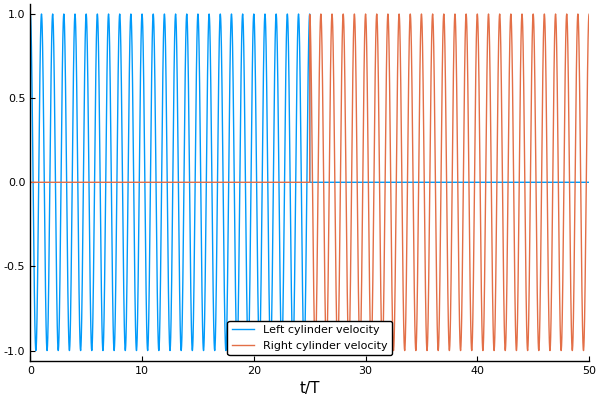

In [21]:
t = range(0.0,stop=50*Tp,length=4001)
uL = map(ti -> real(ml[1](ti)[2]),t) # u component of velocity of centroid
uR = map(ti -> real(ml[2](ti)[2]),t) # u component of velocity of centroid
plot(t/Tp,uL,label="Left cylinder velocity",xlim=(0,maximum(t)/Tp),xlabel="t/T")
plot!(t/Tp,uR,label="Right cylinder velocity")

#### Set up points on the body:

In [22]:
bl = BodyList()
tl = RigidTransform[]

0-element Array{RigidTransform,1}

In [23]:
n = 150
body = Bodies.Circle(1.0,n)
bL = deepcopy(body)
bR = deepcopy(body)

Circular body with 150 points and radius 1.0
   Current position: (0.0,0.0)
   Current angle (rad): 0.0


Transform the body with a specified initial position and orientation.

In [24]:
# left cylinder
cent = (-3.0,0.0)
α = 0.0
TL = RigidTransform(cent,α)
TL(bL) # transform the body to the current configuration

# right cylinder
cent = (3.0,0.0)
α = 0.0
TR = RigidTransform(cent,α)
TR(bR) # transform the body to the current configuration

push!(tl,TL)
push!(tl,TR)

push!(bl,bL)
push!(bl,bR)

2-element Array{Body,1}:
 Circular body with 150 points and radius 1.0
   Current position: (-3.0,0.0)
   Current angle (rad): 0.0

 Circular body with 150 points and radius 1.0
   Current position: (3.0,0.0)
   Current angle (rad): 0.0
 

#### Set up the domain

In [25]:
xlim = (-5.95,5.95)
ylim = (-5.95,5.95)

(-5.95, 5.95)

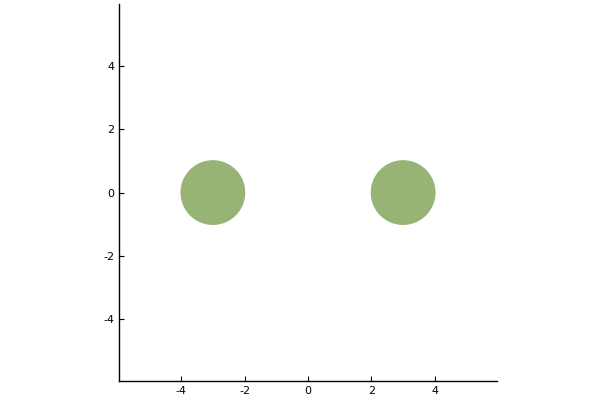

In [13]:
plot(bl,xlim=xlim,ylim=ylim)

### Now set up the system

The discretized equations include the constraint forces on the surface, used to enforce the boundary conditions. The first level can be written as

$\dfrac{dw_1}{dt} - \dfrac{1}{Re}Lw_1 + C^T E^T f_1 = 0,\quad -E C L^{-1}w_1 = \hat{U}, \quad w_1(0) = 0$

where $E$ is the interpolation operator, $E^T$ is the regularization operator, $C^T$ is the rot (curl) operator, and $f_1$ represents the vector of discrete surface forces.

The second asymptotic level is written as

$\dfrac{dw_2}{dt} - \dfrac{1}{Re}Lw_2 + C^T E^T f_2 = -N(w_1),\quad -E C L^{-1}w_2 = \Delta\hat{X}\cdot E G C L^{-1}w_1, \quad w_2(0) = 0$

where $N$ represents the non-linear convective term. We must also advance the state $\Delta\hat{X}$:

$\dfrac{d\Delta\hat{X}}{dt} = \hat{U}, \quad \Delta\hat{X}(0) = 0$

To account for the fluid particle motion, we will also integrate the Eulerian displacement field $\Delta X_1$:

$\dfrac{d\Delta X_1}{dt} = v_1, \quad \Delta X_1(x,0) = 0$


The construction of the NavierStokes system creates and stores the regularization and interpolation matrices. These will not change with time, since the boundary conditions are applied at the initial location of the surface points.



#### Set the cell size and time step size

In [14]:
Δx = 0.02
Δt = min(π*0.5*Δx,π*0.5*Δx^2*Re)

0.025132741228718343

In [26]:
@time solver, sys = ViscousStreaming.initialize_solver(Re,Δx,xlim,ylim,Δt,bl,ml,tl)

173.838241 seconds (2.23 G allocations: 86.528 GiB, 6.93% gc time)


(Order-3 IF-HERK integrator with
   State of type Tuple{Nodes{Dual,600,600},Nodes{Dual,600,600},Edges{Primal,600,600},Array{Float64,1}}
   Force of type Tuple{VectorData{300},VectorData{300},Array{Float64,1},Array{Float64,1}}
   Time step size 0.025132741228718343
, Navier-Stokes system on a grid of size 600 x 600)

### Advance the system

Set the final time to integrate to

In [41]:
tf = 10*2π+Δt

62.85698581302458

Set up a restart writing plan

In [32]:
restart_Δt = 10Δt # rate at which restarts are written
filen = "2cyl_restart_eps"*string(ϵ)*"_dx_"*string(Δx)*"_dt_"*string(Δt)*".jld"
R = WritePlan(filen,restart_Δt,["u","t"])

WritePlan("2cyl_restart_eps0.1_dx_0.02_dt_0.025132741228718343.jld", 0.2513274122871834, ["u", "t"])

Initialize the state vector and the history vectors

In [37]:
initflag = true

if initflag
    t = 0.0
    u = ViscousStreaming.initialize_state(sys,length(bl))
else
    u = load(R,"u")
    t = load(R,"t")
end
T = t+Δt:Δt:tf

nothing

In [38]:
# Initial time to start storing data
tmin_store = 24Tp

# Final time to start storing data
tmax_store = tmin_store + Tp - Δt

# Rate at which to store field data
tsample = Δt

# Rate at which to store field data
S = StorePlan(tmin_store,tmax_store,tsample,u,t,htype=PeriodicHistory)
data_history = initialize_storage(S)
nothing

In [39]:
@time @showprogress for ti in t+Δt:Δt:tf
    global t, u, f = solver(t,u)
    
    store_data!(data_history,t,S,deepcopy(u),t)
    save(t,R,deepcopy(u),t)

end
println("solution completed through time t = ",t)


Progress: 100%|█████████████████████████████████████████| Time: 0:26:05


1565.076059 seconds (2.83 M allocations: 573.839 GiB, 14.35% gc time)
solution completed through time t = 31.441059277125806


#### Compute the velocity field data associated with the stored solution interval

In [ ]:
u₀ = Edges(Primal, u[1])
ux = History(u₀.u,htype=PeriodicHistory)
uy = History(u₀.v,htype=PeriodicHistory)
u1x = History(u₀.u,htype=PeriodicHistory)
u1y = History(u₀.v,htype=PeriodicHistory)
utemp1 = zero(u₀)
@showprogress for i in eachindex(data_history[1])
    utemp1 .=  -ϵ*curl(sys.L\data_history[1][i]) 
    push!(u1x,deepcopy(utemp1.u))
    push!(u1y,deepcopy(utemp1.v))
    utemp1 .+=  -ϵ^2*curl(sys.L\data_history[2][i])
    push!(ux,deepcopy(utemp1.u))
    push!(uy,deepcopy(utemp1.v))
end
vel_history = [ux,uy,u1x,u1y];

#### Store the data for later use

In [ ]:
g = sys.grid
savefile = "./CFD_data/2cylinder_steadyleft_history_eps"*string(ϵ)*"_dx_"*string(Δx)*"_dt_"*string(Δt)*".jld"

In [ ]:
JLD.@save savefile data_history vel_history g Δt

#### Plotting first order solution

In [ ]:
# shorthand name
data = data_history;

In [65]:
iplot = length(data[1]) # index of time step for plotting
ω₁ = vorticity(data[1][iplot],sys)
q₁ = velocity(data[1][iplot],sys)
ψ₁ = streamfunction(data[1][iplot],sys)
nothing

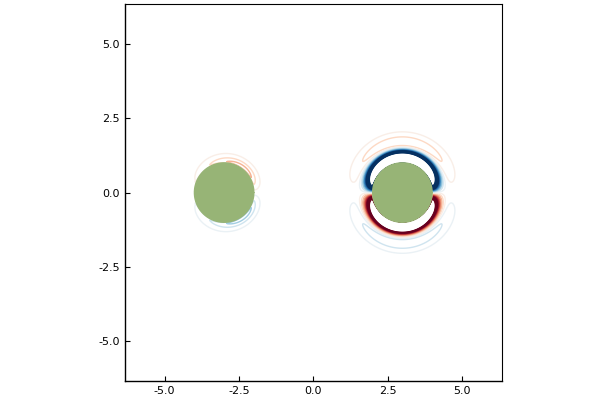

In [66]:
xg,yg = coordinates(u[1],sys.grid)
plot(xg,yg,ω₁,levels=range(-2,2,length=30),clim=(-1,1),color=:RdBu)
plot!(bl)

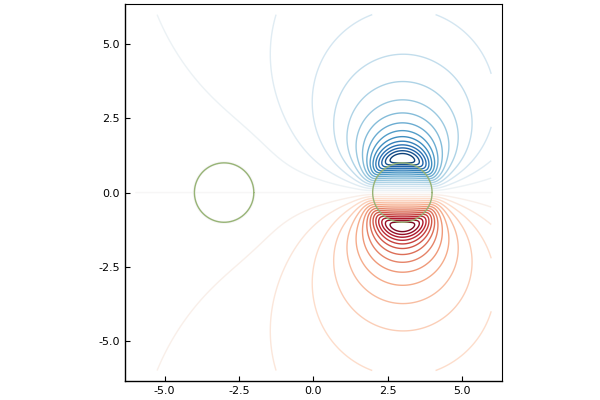

In [46]:
plot(xg,yg,ψ₁,levels=range(-1,1,length=31),color=:RdBu)
plot!(bl,fill=:false)

#### The second-order equation

In [67]:
iplot = length(data[2])
ω₂ = vorticity(data[2][iplot],sys)
q₂ = velocity(data[2][iplot],sys)
ψ₂ = streamfunction(data[2][iplot],sys)
nothing

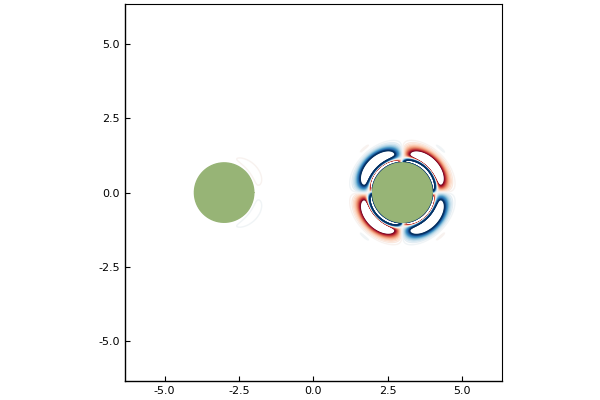

In [68]:
xg,yg = coordinates(u[2],sys.grid)
plot(xg,yg,ω₂,levels=range(-1,1,length=30),color=:RdBu,clim=(-1,1))
plot!(bl)

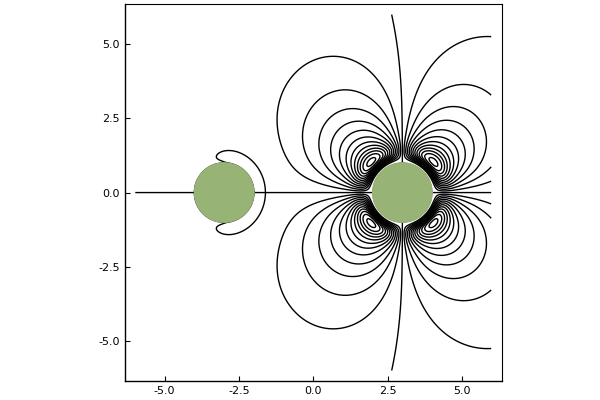

In [69]:
xg,yg = coordinates(u[2],sys.grid)
plot(xg,yg,ψ₂,levels=range(-0.2,0.2,length=31),color=:black,clim=(-0.1,0.1))
plot!(bl)

Compute the mean vorticity field over a period, $\overline{w}_2$

In [70]:
iplot = length(data[2])
itr = iplot-floor(Int,2π/(Ω*Δt))+1:iplot
w2avg = mean(data[2][itr])
ω̄₂ = vorticity(w2avg,sys)
ψ̄₂ = streamfunction(w2avg,sys);

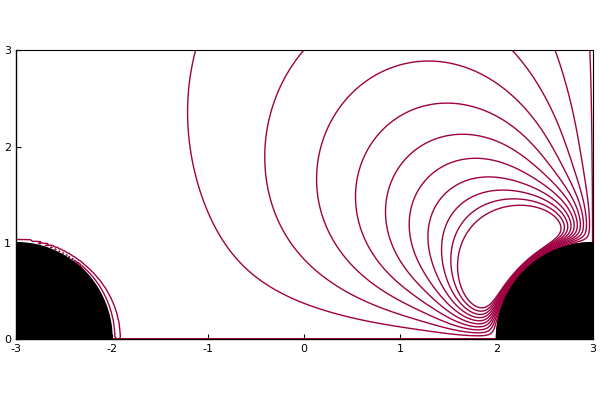

In [71]:
plot(xg,yg,ψ̄₂,levels=range(-0.2,0.1,length=31),clim=(1,2),xlim=(-3,3),ylim=(0,3))
plot!(bl,fillcolor=:black,linecolor=:black)

#### Compute the drift streamfunction

$\psi_d = \frac{1}{2} \overline{v_1 \times \Delta X_1}$

In [72]:
itr = length(data[5])-floor(Int,2π/(Ω*Δt))+1:length(data[5])
vx = zero(u[1]) 
vy = zero(u[1]) 
Xx = zero(u[1]) 
Xy = zero(u[1])
ψd = zero(u[1])
ψdhist = []
for i in itr
    ViscousFlow.Fields.interpolate!((vx,vy),curl(sys.L\data[1][i])) # -v₁, on the dual nodes
    ViscousFlow.Fields.interpolate!((Xx,Xy),data[3][i]) # ΔX₁, on the dual nodes
    ψd .= 0.5*(Xx∘vy-Xy∘vx) # 0.5(v₁ × ΔX₁)
    push!(ψdhist,ψd)
end
ψd .= mean(ψdhist);

#### Plot the streamlines of the mean

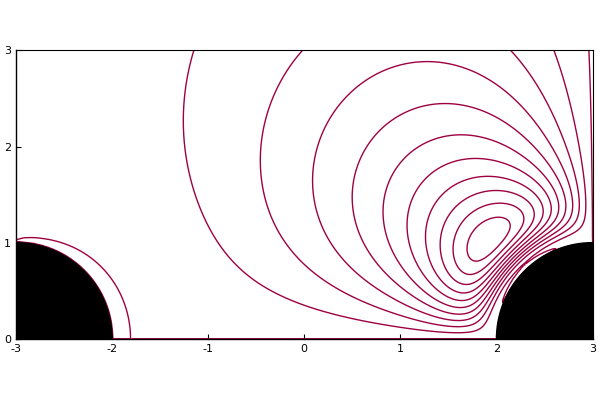

In [73]:
xg,yg = coordinates(u[1],sys.grid)
ψ̄₂d = deepcopy(ψ̄₂)
ψ̄₂d .+= ψd
plot(xg,yg,ψ̄₂d,levels=range(-0.2,0.1,length=31),clim=(1,2),xlim=(-3,3),ylim=(0,3))
plot!(bl,fillcolor=:black,linecolor=:black)